<a href="https://colab.research.google.com/github/abdu18/Chest-Xray-Pneumonia-Classifiction/blob/master/Chest_Xray_Pneumonia_Classifiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os, random, gc, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import cv2
import keras
import seaborn as sns
from numpy.random import seed


Using TensorFlow backend.


In [0]:
#@title
os.environ['KAGGLE_USERNAME'] = "xxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxxxxxxxxxxxxxxxxxxx"

seed(100)


In [0]:
def search_dir(type="normal", num=6):
  #Helper function to scan contents of directory
  counter=0

  for file in os.listdir(train_dir + type.upper()+ "/"):
      if counter == num:
          break

      if file.endswith(".jpeg"):
          print(file)

      counter += 1

In [0]:
def plot_images(type="normal", num=6):
  #Helper function to plot images
  counter=0
  fig = plt.figure(figsize=(10, 8))
  

  for file in os.listdir(train_dir + type.upper()):

      if file.endswith(".jpeg"):
          if counter == num:
              break

          img = mpimg.imread(train_dir + type.upper()+"/"+file)
          plt.subplot(231+counter)
          plt.title(file.split('.')[0])
          imgplot = plt.imshow(img)

          counter += 1

In [0]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

**Datasets Download**

In [6]:
%time !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia 

100% 2.29G/2.29G [00:58<00:00, 48.7MB/s]
100% 2.29G/2.29G [00:58<00:00, 42.4MB/s]
CPU times: user 449 ms, sys: 76.8 ms, total: 525 ms
Wall time: 1min 2s


In [7]:
%time !unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: CPU times: user 2.43 s, sys: 292 ms, total: 2.73 s
Wall time: 14min 58s


In [8]:
%time !unzip chest_xray.zip

unzip:  cannot find or open chest_xray.zip, chest_xray.zip.zip or chest_xray.zip.ZIP.
CPU times: user 20.2 ms, sys: 11.2 ms, total: 31.4 ms
Wall time: 1.94 s


In [0]:
os.remove("chest-xray-pneumonia.zip") # clean up directory a bit

**Exploratory Data Analysis (EDA)**

In [0]:
#Point to the relevant directories
train_dir = "chest_xray/train/"
val_dir   = "chest_xray/test/" #directories for training

test_dir  = "chest_xray/val/" #directory for final model scoring

In [11]:
search_dir(type="pneumonia", num=10)

person319_virus_645.jpeg
person543_bacteria_2282.jpeg
person702_virus_1299.jpeg
person1475_virus_2558.jpeg
person1771_bacteria_4615.jpeg
person1521_virus_2649.jpeg
person111_virus_209.jpeg
person1243_virus_2110.jpeg
person299_bacteria_1414.jpeg
person1745_bacteria_4584.jpeg


In [12]:
search_dir(type="normal", num=10)

IM-0187-0001.jpeg
NORMAL2-IM-1321-0001.jpeg
NORMAL2-IM-0992-0001.jpeg
NORMAL2-IM-1314-0001.jpeg
NORMAL2-IM-1419-0001.jpeg
IM-0290-0001.jpeg
IM-0516-0001.jpeg
NORMAL2-IM-0969-0001.jpeg
IM-0499-0001.jpeg
IM-0494-0001.jpeg


In [0]:
training_dir = './chest_xray/train'
validation_dir = './chest_xray/test'
test_dir = './chest_xray/val'

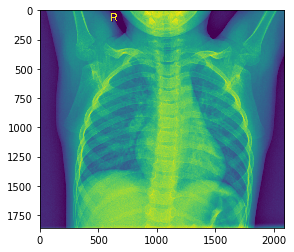

In [14]:
img = mpimg.imread(training_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

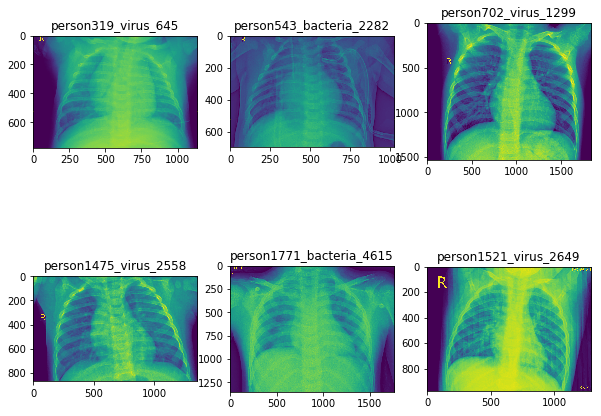

In [15]:
plot_images(type="pneumonia", num=6)

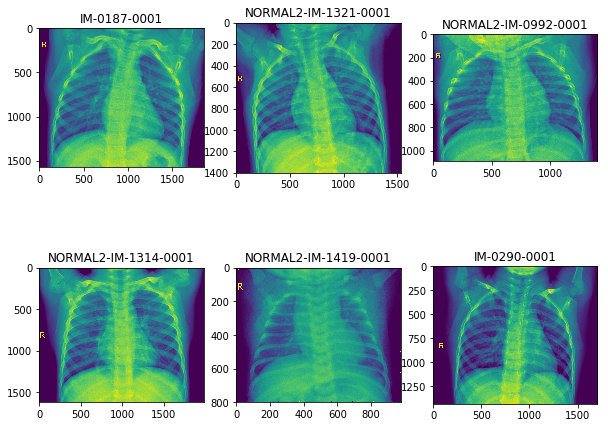

In [16]:
plot_images(type="normal", num=6)

**Modeling**

**Pre-Trained Model w/o Transfer Learning**

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions

from tensorflow.python.keras.preprocessing import image

In [18]:
pre_model = InceptionV3(weights='imagenet')

In [19]:
img = image.load_img( "/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg", 
                     target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = pre_model.predict(x)
for index, res in enumerate(decode_predictions(y)[0]):
    print('{}. {}: {:.3f}%'.format(index + 1, res[1], 100 * res[2]))

1. water_bottle: 73.426%
2. isopod: 16.616%
3. scorpion: 1.624%
4. trilobite: 0.468%
5. water_jug: 0.425%


In [41]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,  target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
) 

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
def get_model():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(2, activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = False
  
  model.summary()
  return model

In [22]:
model = get_model()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

**Data Preparation**

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
batch_size=163


#Create training data generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1) #Create image generator in the abstract

In [25]:
train_generator = train_datagen.flow_from_directory(
        train_dir, #directory that contains training data
        target_size=(150, 150), #what size image we want
        batch_size=batch_size, #how many files to read in at a time
        class_mode="categorical")

Found 5216 images belonging to 2 classes.


In [26]:
#Create validation data generator

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode="categorical")

Found 624 images belonging to 2 classes.


In [27]:
#Create validation test generator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode="categorical",
        shuffle=False)

Found 16 images belonging to 2 classes.


**Model Training**

In [0]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)


for layer in base_model.layers:
  layer.trainable = False  # Freeze the layers not to train
  
final_model = keras.models.Model(inputs=base_model.inputs, outputs=predictions) #create final model

In [29]:
final_model.compile(loss ="categorical_crossentropy", #another term for log loss
                    optimizer = "adam", 
                    metrics=["accuracy"])

In [30]:
fit_history = final_model.fit_generator(
        train_generator, #train data generator 
        steps_per_epoch=len(train_generator),
        epochs=5,
        validation_data=val_generator, #validation data generator 
        validation_steps=len(val_generator))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
32/32 [==============================] - 99s 3s/step - loss: 0.5396 - acc: 0.8255 - val_loss: 2.1760 - val_acc: 0.6795
Epoch 2/5
32/32 [==============================] - 87s 3s/step - loss: 0.2454 - acc: 0.9059 - val_loss: 1.5510 - val_acc: 0.6955
Epoch 3/5
32/32 [==============================] - 89s 3s/step - loss: 0.2328 - acc: 0.9036 - val_loss: 1.2644 - val_acc: 0.7179
Epoch 4/5
32/32 [==============================] - 89s 3s/step - loss: 0.2164 - acc: 0.9181 - val_loss: 1.4060 - val_acc: 0.7228
Epoch 5/5
32/32 [==============================] - 89s 3s/step - loss: 0.2227 - acc: 0.9091 - val_loss: 2.9970 - val_acc: 0.6715


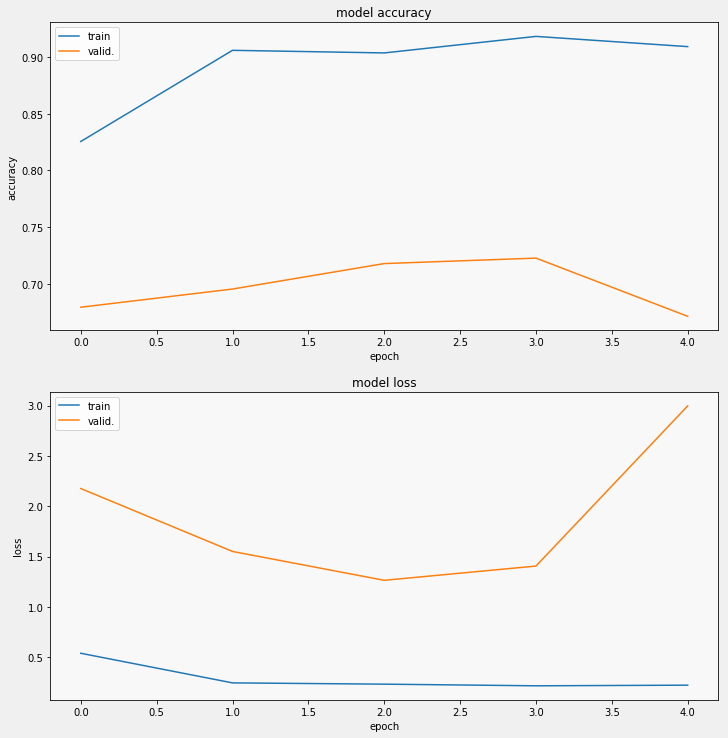

In [31]:
display_training_curves(fit_history.history['acc'], fit_history.history['val_acc'], 'accuracy', 211)
display_training_curves(fit_history.history['loss'], fit_history.history['val_loss'], 'loss', 212)

In [32]:
result  = final_model.evaluate_generator(test_generator,steps=len(test_generator))
print('Loss:', result[0])
print('Accuracy:', result[1])

Loss: 2.678151028707129
Accuracy: 0.625


In [44]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

vl_score = model.predict_generator(test_generator)

classes = ['Normal', 'Pneumonia']
print(classification_report(test_generator.classes,
                            np.argmax(vl_score, axis=1),
                            target_names=classes))


              precision    recall  f1-score   support

      Normal       0.50      1.00      0.67         8
   Pneumonia       0.00      0.00      0.00         8

    accuracy                           0.50        16
   macro avg       0.25      0.50      0.33        16
weighted avg       0.25      0.50      0.33        16



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [34]:
#Generate all predictions
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = final_model.predict_generator(test_generator,steps = nb_samples).argmax(axis=-1)

predict

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [35]:
#Generate true labels
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [36]:
y_pred_batches = []
y_true_batches = []
y_img_batches = []

for i in range(0, len(test_generator)):
  y_img_batch, y_true_batch = test_generator[i]
  y_true_batch = y_true_batch.argmax(axis=-1)
  y_img_batches.append(y_img_batch)
  y_true_batches.append(y_true_batch)

  y_pred_batch = model.predict(y_img_batch)
  y_pred_batch = y_pred_batch.argmax(axis=-1)
  y_pred_batches.append(y_pred_batch)

y_pred_batches

[array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0])]

In [0]:
def predict_images(images_path, label):
  amount = 0
  fig = plt.figure(figsize=(18, 8))

  for file in os.listdir(images_path):
    if file.endswith('.jpeg'):
      if amount == 8:
        break

      img = mpimg.imread(os.path.join(images_path, file))
      plt.subplot(241+amount)
      plt.title('{} ---- {}'.format(label, 'NORMAL' if y_pred_batches[amount] == 0 else 'PNEUMONIA'))
      imgplot = plt.imshow(img)

      amount += 1

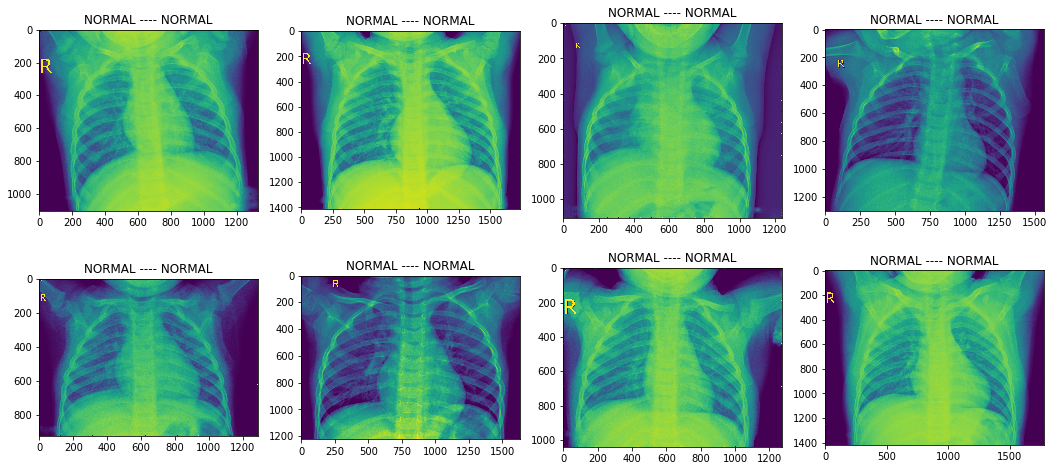

In [38]:
predict_images('./chest_xray/val/NORMAL', 'NORMAL')

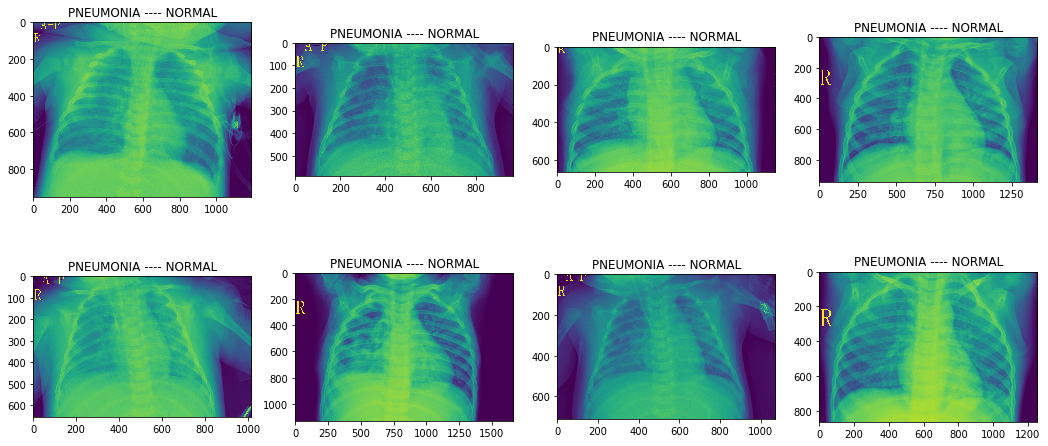

In [39]:
predict_images('./chest_xray/val/PNEUMONIA', 'PNEUMONIA')